In [1]:
%load_ext autoreload
%autoreload 2
%env GAMMAPY_DATA=/home/mnievas/Software/cta/gammapy/gammapy-datasets/

import sys
import os
import glob

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from utils import (
    mkdir_p,
)
from gammapy_ogip.ogip_spectrum_dataset import StandardOGIPDataset
from gammapy.data import GTI

from gammapy.datasets import (
    Datasets
)
from gammapy.modeling.models import (
    SkyModel,
    Models,
    LogParabolaSpectralModel,
    PowerLawNormSpectralModel,
    FoVBackgroundModel,
)

import numpy as np
from astropy import units as u 
from astropy.io import fits as pyfits
from astropy.time import Time
from matplotlib import pyplot as plt

env: GAMMAPY_DATA=/home/mnievas/Software/cta/gammapy/gammapy-datasets/


## uvot2pha

For UVOT, we need to generate PHA files using uvot2pha. To make it simple, define a wrapper script, e.g. 

    /home/mnievas/Software/swift/uvot2pha_wrapper.sh

with the following contents

    #!/bin/bash 

    export CALDBCONFIG=/home/mnievas/Software/CALDB_REMOTE/caldb.config
    export CALDBALIAS=/home/mnievas/Software/CALDB_REMOTE/alias_config.fits
    export CALDB=https://heasarc.gsfc.nasa.gov/FTP/caldb
    export HEADAS=/home/mnievas/Software/heasoft-6.29/x86_64-pc-linux-gnu-libc2.35
    source ${HEADAS}/headas-init.sh
    
    # Bourne shell (sh/bash):
    export HEADASNOQUERY=
    
    export HEADASPROMPT=/dev/null
    
    uvot2pha $@

That is not it, as we have to update the hdu headers of the file to point to the local RSP file that we nbeed to fetch from CALDB.

The code would look like:

In [2]:
# We need to edit manually the header and download the response files
list_of_uvot_dirs = [f"/home/mnievas/Swift/OP313/reproc/00089816002"]

for uvot_dir in list_of_uvot_dirs:
    print("directory:",uvot_dir)
    images = glob.glob(f"{uvot_dir}/uvotproduct/*sk.src.pha")
    #print(uvot_dir,images)
    srcreg = uvot_dir+'/uvotproduct/source.reg'
    bgdreg = uvot_dir+'/uvotproduct/background.reg'

    for infile in images:
        print("->",infile)
        srcpha = uvot_dir+f'/uvotproduct/{infile.split("/")[-1]}'
        bgdpha = uvot_dir+f'/uvotproduct/{infile.split("/")[-1].replace("_src.pha","_bkg.pha")}'
        srcreg = f"/home/mnievas/Swift/OP313/reproc/00089816002/uvotproduct/source.{os.path.basename(infile).split('.')[0]}.reg"
        bgdreg = f"/home/mnievas/Swift/OP313/reproc/00089816002/uvotproduct/background.{os.path.basename(infile).split('.')[0]}.reg"
        respfile = "CALDB"
        
        if not os.path.exists(srcpha) or not os.path.exists(bgdpha):    
            cmd = f"/home/mnievas/Software/swift/uvot2pha_wrapper.sh phatype=counts clobber=yes "\
              f"infile={infile}+1 srcreg={srcreg} bkgreg={bgdreg} "\
              f"srcpha={srcpha} bkgpha={bgdpha} respfile={respfile} "

            # extract the source and background pha
            os.system(cmd)

        # Modify the respfile keyword to point locally and download the rsp file
        if os.path.exists(srcpha) and os.path.exists(bgdpha):
            with pyfits.open(srcpha, mode='update') as hdul:
                hdr = hdul[1].header
                respfileremote = hdr['RESPFILE']
                localfile = f"{uvot_dir}/uvotproduct/{respfileremote.split('/')[-1]}"
                if not os.path.exists(localfile):
                    hdr['RESPFILE'] = respfileremote.split("/")[-1]

                    print(" ... " f"wget -c -O {localfile} {respfileremote}")
                    os.system(f"wget -c -O {localfile} {respfileremote}")
                else:
                    print(" ... RESPFILE already downloaded, HDUs updated.")
                    hdr['RESPFILE'] = respfileremote.split("/")[-1]



directory: /home/mnievas/Swift/OP313/reproc/00089816002
-> /home/mnievas/Swift/OP313/reproc/00089816002/uvotproduct/sw00089816002um2_sk.src.pha
 ... RESPFILE already downloaded, HDUs updated.


In [3]:
uvot_phas = glob.glob(f"/home/mnievas/Swift/OP313/reproc/00089816002/uvotproduct/sw*sk.src.pha");
uvot_dataset = {f: StandardOGIPDataset.read(f) for f in uvot_phas}
uvot_dataset_on_off = {f: uvot_dataset[f].to_spectrum_dataset_onoff(name=f.split('/')[-1].split('_sk')[0]) \
                       for f in uvot_dataset}
for f in uvot_dataset_on_off:
    with pyfits.open(f) as hdu:
        tinterval = Time([hdu[1].header['DATE-OBS'],hdu[1].header['DATE-END']])
        uvot_dataset_on_off[f].gti = GTI.from_time_intervals([tinterval])
uvot_selected_datasets = Datasets(list(uvot_dataset_on_off.values()))

In [4]:
### Sky models
def get_1d_pwl_skymodel(name):
    s = LogParabolaSpectralModel()
    s.reference.value = 1
    s.reference.unit  = 'eV'
    s.amplitude.value = 100
    s.amplitude.unit = 'eV-1 s-1 cm-2'
    s.amplitude.min  = 1e-6
    s.amplitude.max  = 1e6
    s.alpha.value = 2
    s.alpha.min  = -2.0
    s.alpha.max  = 8.0
    s.beta.value = 0.1
    s.beta.min  = -2.0
    s.beta.max  = 2.0
    skymodel = SkyModel(name=name, spectral_model=s)
    return(skymodel)

OP313_SkyModel = get_1d_pwl_skymodel(name='OP313')

uvot_selected_datasets.models = Models([OP313_SkyModel])

In [5]:
# Save and compress the datasets
basedir = os.path.abspath("../../../")
outdir  = f"{basedir}/UVOT/MJD60384/"
mkdir_p(outdir)
for g in glob.glob(f"{outdir}/*.yaml*"): os.remove(g)
for g in glob.glob(f"{outdir}/*.fits*"): os.remove(g)

uvot_selected_datasets.write(filename=f"{outdir}/dataset.yaml",
                             filename_models=f"{outdir}/models.yaml",
                             write_covariance=False,
                             overwrite=True)

#!gzip {outdir}/*.fits
#!sed -i 's/.fits/.fits.gz/g' {outdir}/dataset.yaml

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 60384.050984 from DATE-OBS.
Set MJD-END to 60384.062454 from DATE-END'. [astropy.wcs.wcs]


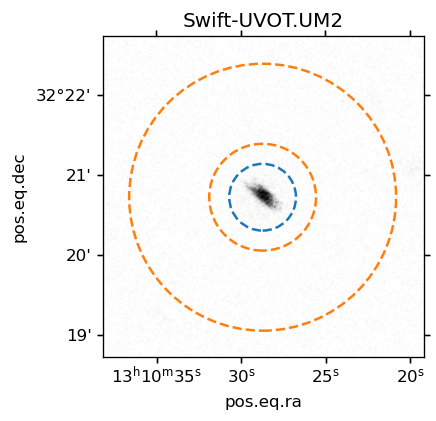

In [8]:
import matplotlib.pyplot as plt
import glob
from astropy.io import fits as pyfits
from astropy.visualization import AsinhStretch, PercentileInterval
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.ndimage import gaussian_filter
from regions import Regions

# List of defocused images
defocused_images = []

# Prepare the figure
fig = plt.figure(figsize=(7, 3.5), dpi=120)

# Loop through the images
l=0
for k, f in enumerate(sorted(glob.glob("/home/mnievas/Swift/OP313/reproc/00089816002/uvot/image/*sk.img.gz"))):
    hdu = pyfits.open(f)
    # Load the source and background regions
    srcreg_path = f"/home/mnievas/Swift/OP313/reproc/00089816002/uvotproduct/source.{os.path.basename(f).split('.')[0]}.reg"
    bgdreg_path = f"/home/mnievas/Swift/OP313/reproc/00089816002/uvotproduct/background.{os.path.basename(f).split('.')[0]}.reg"
    # Read regions
    srcreg = Regions.read(srcreg_path, format='ds9')
    bgdreg = Regions.read(bgdreg_path, format='ds9')
    # Create a transformation for image scaling
    transform = AsinhStretch() + PercentileInterval(99.99)
    # Create a cutout of the image
    cutoutdata = Cutout2D(hdu[1].data, position=SkyCoord.from_name('OP313'), size=4 * u.arcmin, wcs=WCS(hdu[1]))
    # Add subplot
    ax = fig.add_subplot(1, 2, l+1, projection=cutoutdata.wcs)
    # Show the image
    ax.imshow(transform(gaussian_filter(cutoutdata.data, 0.5)), cmap='Greys', vmax=1)
    # Plot the source region
    for region in srcreg:
        pixel_region = region.to_pixel(cutoutdata.wcs)
        pixel_region.plot(ax=ax, edgecolor='tab:blue', facecolor='none', lw=1.5,ls='dashed')
    # Plot the background region (annulus)
    for region in bgdreg:
        pixel_region = region.to_pixel(cutoutdata.wcs)
        pixel_region.plot(ax=ax, edgecolor='tab:orange', facecolor='none', lw=1.5,ls='dashed')
    if 'uvv' in f:
        ax.set_title('Swift-UVOT.V')
    elif 'ubv' in f:
        ax.set_title('Swift-UVOT.B')
    elif 'ubv' in f:
        ax.set_title('Swift-UVOT.U')
    elif 'uw1' in f:
        ax.set_title('Swift-UVOT.UW1')
    elif 'um2' in f:
        ax.set_title('Swift-UVOT.UM2')
    elif 'uw2' in f:
        ax.set_title('Swift-UVOT.UW2')
    l+=1

plt.tight_layout()
!mkdir -p {basedir}/Figures/MJD60384/Swift-UVOT/
fig.savefig(f"{basedir}/Figures/MJD60384/Swift-UVOT/SwiftUVOT_images.pdf",bbox_inches="tight")

In [7]:
pyfits.open("/home/mnievas/Swift/OP313/reproc/00089816002/uvot/image/sw00089816002um2_sk.img.gz")

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f23fc882010>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f23fc77c090>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f23fc77ef90>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f23fc78d790>]